In [24]:
import pandas as pd
import numpy as np

# 날짜
import datetime as dt

#시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 딥러닝
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adadelta,Adam,RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

pd.options.display.float_format = '{:.5f}'.format

In [2]:
# 데이터 로드
df = pd.read_csv("./data/bus_0308_9am.csv")

In [3]:
# 데이터 프레임 상단 5개 조회
df.head(5)

,bstopId,routeNo,routeId,bstopNm,busId,LATEST_STOP_NAME,Bus_Num_Plate,Rest_Stop_Count,ARRIVALESTIMATETIME,ThisDT
0,113000424,M6724,165000381,합정역,7331704,동춘역(이마트.스퀘어원),인천73아1704,5,2757,2022-02-16 15:05:22
1,164000346,M6724,165000381,동춘역,7331707,부천IC출입(미정차),인천73아1707,1,1649,2022-02-16 15:05:24
2,113000424,M6724,165000381,합정역,7331704,동춘역(이마트.스퀘어원),인천73아1704,5,2633,2022-02-16 15:06:01
3,164000346,M6724,165000381,동춘역,7331707,부천IC출입(미정차),인천73아1707,1,1616,2022-02-16 15:06:03
4,113000424,M6724,165000381,합정역,7331704,동춘역(이마트.스퀘어원),인천73아1704,5,2648,2022-02-16 15:06:29


In [4]:
# 인덱스 유니크값 수 = 전체 데이터 수
df.index.nunique()

65444

In [5]:
# 데이터 ThisDT 변수 datatime 타입으로 변환
df['ThisDT'] =  pd.to_datetime(df['ThisDT'])

In [6]:
df['ThisDT']

0       2022-02-16 15:05:22
1       2022-02-16 15:05:24
2       2022-02-16 15:06:01
3       2022-02-16 15:06:03
4       2022-02-16 15:06:29
                ...        
65439   2022-03-08 09:31:06
65440   2022-03-08 09:31:32
65441   2022-03-08 09:31:34
65442   2022-03-08 09:32:00
65443   2022-03-08 09:32:03
Name: ThisDT, Length: 65444, dtype: datetime64[ns]

In [7]:
# 날짜 변수 생성
df['year'] = df['ThisDT'].dt.year
df['month'] = df['ThisDT'].dt.month
df['day'] = df['ThisDT'].dt.day
df['hour'] = df['ThisDT'].dt.hour
df['minute'] = df['ThisDT'].dt.minute
df['second'] = df['ThisDT'].dt.second
# 요일 생성
# df['weekno'] = df['ThisDT'].dt.weekday
# 평일 주말 구분
# df['weekday'] = 0
# 평일은 0
# cond = (df['weekno'] < 5)
# df.loc[cond, 'weekday'] = 0
# 주말은 1
# cond = (df['weekno'] >= 5)
# df.loc[cond, 'weekday'] = 0

# df.drop(columns = ['weekno'], inplace=True)

In [8]:
# 고유값이 1인 변수 제거 > 분석에 무의미
# bstopNm 제거 > bstopId 와 의미 중복
df.drop(columns=['routeNo', 'routeId', 'bstopNm', 'year'], inplace=True)

In [9]:
df.tail(5)

,bstopId,busId,LATEST_STOP_NAME,Bus_Num_Plate,Rest_Stop_Count,ARRIVALESTIMATETIME,ThisDT,month,day,hour,minute,second
65439,164000346,7331703,부천IC출입(미정차),인천73아1703,1,731,2022-03-08 09:31:06,3,8,9,31,6
65440,113000424,7331708,동춘역(이마트.스퀘어원),인천73아1708,5,2077,2022-03-08 09:31:32,3,8,9,31,32
65441,164000346,7331703,부천IC출입(미정차),인천73아1703,1,731,2022-03-08 09:31:34,3,8,9,31,34
65442,113000424,7331708,동춘역(이마트.스퀘어원),인천73아1708,5,1898,2022-03-08 09:32:00,3,8,9,32,0
65443,164000346,7331703,부천IC출입(미정차),인천73아1703,1,639,2022-03-08 09:32:03,3,8,9,32,3


In [10]:
# 문자형 컬럼 원핫인코딩
df = pd.get_dummies(df, columns = ['LATEST_STOP_NAME', 'Bus_Num_Plate'])

In [11]:
df

,bstopId,busId,Rest_Stop_Count,ARRIVALESTIMATETIME,ThisDT,month,day,hour,minute,second,...,LATEST_STOP_NAME_홍대입구역(가상),Bus_Num_Plate_인천73아1348,Bus_Num_Plate_인천73아1701,Bus_Num_Plate_인천73아1702,Bus_Num_Plate_인천73아1703,Bus_Num_Plate_인천73아1704,Bus_Num_Plate_인천73아1705,Bus_Num_Plate_인천73아1706,Bus_Num_Plate_인천73아1707,Bus_Num_Plate_인천73아1708
0,113000424,7331704,5,2757,2022-02-16 15:05:22,2,16,15,5,22,...,0,0,0,0,0,1,0,0,0,0
1,164000346,7331707,1,1649,2022-02-16 15:05:24,2,16,15,5,24,...,0,0,0,0,0,0,0,0,1,0
2,113000424,7331704,5,2633,2022-02-16 15:06:01,2,16,15,6,1,...,0,0,0,0,0,1,0,0,0,0
3,164000346,7331707,1,1616,2022-02-16 15:06:03,2,16,15,6,3,...,0,0,0,0,0,0,0,0,1,0
4,113000424,7331704,5,2648,2022-02-16 15:06:29,2,16,15,6,29,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65439,164000346,7331703,1,731,2022-03-08 09:31:06,3,8,9,31,6,...,0,0,0,0,1,0,0,0,0,0
65440,113000424,7331708,5,2077,2022-03-08 09:31:32,3,8,9,31,32,...,0,0,0,0,0,0,0,0,0,1
65441,164000346,7331703,1,731,2022-03-08 09:31:34,3,8,9,31,34,...,0,0,0,0,1,0,0,0,0,0
65442,113000424,7331708,5,1898,2022-03-08 09:32:00,3,8,9,32,0,...,0,0,0,0,0,0,0,0,0,1


# 스케일링

In [12]:
# 최대 최소
print("최대: ", df.ARRIVALESTIMATETIME.max())
print("최소: ", df.ARRIVALESTIMATETIME.min())

최대:  5346
최소:  18


In [13]:
# y = scaled_y * (5346-18) + 18

In [14]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['ARRIVALESTIMATETIME']

# scaler.fit(df_train_y)

# df_train_x = scaler.transform(df_train_x)
# df_test_x = scaler.transform(df_test_x)

# df_train_y = scaler.transform(df_train_y)
# df_test_y = scaler.transform(df_test_y)
# X_origin = minmax_scaler.inverse_transform(X_train_scaled)



df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

concat_df = df.copy()
concat_df.drop(columns=scale_cols, inplace=True)

df = pd.concat([concat_df, df_scaled], axis=1)

In [15]:
# 학습과 테스트 데이터 분리
# 22일 전 후로 생성
df_train = df.query('ThisDT <= "2022-02-23"').copy()
df_test = df.query('ThisDT > "2022-02-23"').copy()

In [16]:
# datetime 날짜 제거 > 모델 학습에 datetime 형식 지원 안 함
df_train.drop(columns = ['ThisDT'], inplace=True)
df_test.drop(columns = ['ThisDT'], inplace=True)
# df_test = df_test.set_index('ThisDT')
# df_train = df_train.set_index('ThisDT')

In [17]:
# x, y 분리
df_train_y = df_train.loc[:,'ARRIVALESTIMATETIME']
df_train_x = df_train.drop('ARRIVALESTIMATETIME', axis=1)
df_test_y = df_test.loc[:,'ARRIVALESTIMATETIME']
df_test_x = df_test.drop('ARRIVALESTIMATETIME', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_test.loc[:, ['ARRIVALESTIMATETIME']]


In [18]:
#3차원 배열로 변환
train_x = np.array(df_train_x).reshape(df_train_x.shape[0], df_train_x.shape[1], 1)
test_x = np.array(df_test_x).reshape(df_test_x.shape[0], df_test_x.shape[1], 1)

In [19]:
test_x.shape

(31794, 35, 1)

In [20]:
#GPU 사용 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [21]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



Epoch 1/10
3029/3029 [==============================] - 23s 5ms/step - loss: 0.0309 - mae: 0.1443 - val_loss: 0.0219 - val_mae: 0.1256
Epoch 2/10
3029/3029 [==============================] - 15s 5ms/step - loss: 0.0219 - mae: 0.1220 - val_loss: 0.0199 - val_mae: 0.1189
Epoch 3/10
3029/3029 [==============================] - 16s 5ms/step - loss: 0.0192 - mae: 0.1117 - val_loss: 0.0169 - val_mae: 0.1041
Epoch 4/10
3029/3029 [==============================] - 16s 5ms/step - loss: 0.0159 - mae: 0.1001 - val_loss: 0.0124 - val_mae: 0.0881
Epoch 5/10
3029/3029 [==============================] - 15s 5ms/step - loss: 0.0126 - mae: 0.0877 - val_loss: 0.0087 - val_mae: 0.0689
Epoch 6/10
3029/3029 [==============================] - 15s 5ms/step - loss: 0.0105 - mae: 0.0781 - val_loss: 0.0078 - val_mae: 0.0647
Epoch 7/10
3029/3029 [==============================] - 15s 5ms/step - loss: 0.0094 - mae: 0.0737 - val_loss: 0.0082 - val_mae: 0.0672
Epoch 8/10
3029/3029 [==============================] -

<AxesSubplot:>

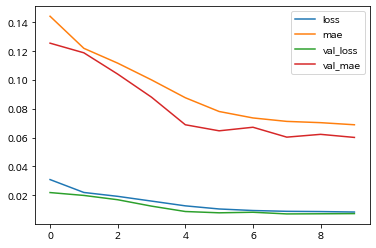

In [34]:
# input shape에 전처리된 train_x의 형태를 넣는다
# 20%로 Drop-out 했다

#activation='relu'
model = keras.Sequential()
model.add(keras.layers.LSTM(units=16,input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
# model.add(keras.layers.Dense(units=4))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

callbacks = [
# `val_loss`가 2번의 에포크에 걸쳐 향상되지 않으면 훈련을 멈춥니다.
tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
# `./logs` 디렉토리에 텐서보드 로그를 기록니다.
# tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

plot_losses = PlotLosses() # ADD

# 10개의 batch로 100번 epoch 함
history = model.fit(train_x, df_train_y, validation_split=0.1, batch_size=10, epochs=10, callbacks=[callbacks])

pd.DataFrame.from_dict(history.history).plot()

In [35]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

predictions = model.predict(test_x)

# r_sq = model.score(df_test_x, df_test_y)
mse = mean_squared_error(df_test_y, predictions)
rmse = np.sqrt(mse)
r2_ = r2_score(df_test_y, predictions)


print('R2 score(결정계수) = {:.3f}'.format(r2_))
# print('explained_variance_score(설명분산점수) : {0:.3f}'.format(explained_variance_score(predictions,df_test_y)))
print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))

R2 score(결정계수) = 0.658
MSE : 0.013 , RMSE : 0.114


In [36]:
predictions.shape

(31794, 1)

In [21]:
test_x

array([[[113000412],
        [  7331706],
        [        2],
        ...,
        [        1],
        [        0],
        [        0]],

       [[113000424],
        [  7331708],
        [        3],
        ...,
        [        0],
        [        0],
        [        1]],

       [[164000346],
        [  7331706],
        [        6],
        ...,
        [        1],
        [        0],
        [        0]],

       ...,

       [[164000346],
        [  7331703],
        [        1],
        ...,
        [        0],
        [        0],
        [        0]],

       [[113000424],
        [  7331708],
        [        5],
        ...,
        [        0],
        [        0],
        [        1]],

       [[164000346],
        [  7331703],
        [        1],
        ...,
        [        0],
        [        0],
        [        0]]], dtype=int64)

In [25]:
df_train_y[df_train_y.index < 10]

0   0.51408
1   0.30612
2   0.49080
3   0.29992
4   0.49362
5   0.29992
6   0.47372
7   0.30612
8   0.47635
9   0.30612
Name: ARRIVALESTIMATETIME, dtype: float64

In [27]:
df_for_test = df_train_x[df_train_x.index == 9]
df_for_test

# df_tf = np.array(df_for_test).reshape(df_for_test.shape[0], df_for_test.shape[1], 1)

,bstopId,busId,Rest_Stop_Count,month,day,hour,minute,second,LATEST_STOP_NAME_더샵엑스포빌리지,LATEST_STOP_NAME_동춘역(이마트.스퀘어원),...,LATEST_STOP_NAME_홍대입구역(가상),Bus_Num_Plate_인천73아1348,Bus_Num_Plate_인천73아1701,Bus_Num_Plate_인천73아1702,Bus_Num_Plate_인천73아1703,Bus_Num_Plate_인천73아1704,Bus_Num_Plate_인천73아1705,Bus_Num_Plate_인천73아1706,Bus_Num_Plate_인천73아1707,Bus_Num_Plate_인천73아1708
9,164000346,7331707,1,2,16,15,7,29,0,0,...,0,0,0,0,0,0,0,0,1,0


In [28]:
df_for_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 9 to 9
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   bstopId                         1 non-null      int64
 1   busId                           1 non-null      int64
 2   Rest_Stop_Count                 1 non-null      int64
 3   month                           1 non-null      int64
 4   day                             1 non-null      int64
 5   hour                            1 non-null      int64
 6   minute                          1 non-null      int64
 7   second                          1 non-null      int64
 8   LATEST_STOP_NAME_더샵엑스포빌리지       1 non-null      uint8
 9   LATEST_STOP_NAME_동춘역(이마트.스퀘어원)  1 non-null      uint8
 10  LATEST_STOP_NAME_부천IC진입(미정차)    1 non-null      uint8
 11  LATEST_STOP_NAME_부천IC출입(미정차)    1 non-null      uint8
 12  LATEST_STOP_NAME_서울역            1 non-null      uint8
 13  LATEST_ST

In [35]:
df_for_test = df_for_test.astype('float')
df_for_test.info()
df_for_test.to_csv('./test_data.csv', header=True, index=False, encoding="utf-8-sig")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 9 to 9
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bstopId                         1 non-null      float64
 1   busId                           1 non-null      float64
 2   Rest_Stop_Count                 1 non-null      float64
 3   month                           1 non-null      float64
 4   day                             1 non-null      float64
 5   hour                            1 non-null      float64
 6   minute                          1 non-null      float64
 7   second                          1 non-null      float64
 8   LATEST_STOP_NAME_더샵엑스포빌리지       1 non-null      float64
 9   LATEST_STOP_NAME_동춘역(이마트.스퀘어원)  1 non-null      float64
 10  LATEST_STOP_NAME_부천IC진입(미정차)    1 non-null      float64
 11  LATEST_STOP_NAME_부천IC출입(미정차)    1 non-null      float64
 12  LATEST_STOP_NAME_서울역            1 non-nu

In [38]:
# np.save( './np', df_tf)

In [39]:
df_for_test.shape

(10, 35)

In [40]:
df_tf.shape

NameError: name 'df_tf' is not defined

In [37]:
predictions = model.predict(df_tf)
predictions

array([[0.36245513]], dtype=float32)

In [38]:
print(df_tf)

[[[113000424]
  [  7331704]
  [        5]
  [        2]
  [       16]
  [       15]
  [        5]
  [       22]
  [        0]
  [        1]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        0]
  [        1]
  [        0]
  [        0]
  [        0]
  [        0]]]


In [29]:
df_for_test2.info()

NameError: name 'df_for_test2' is not defined

In [ ]:
df_for_test2 = pd.read_csv('test.csv', encoding='cp949', header=None)
df_for_test2

In [ ]:
predictions = model.predict(df_tf)
predictions

In [ ]:
predictions = model.predict(df_for_test)
predictions

In [ ]:
predictions = model.predict(df_for_test2)
predictions

# 모델 저장

In [ ]:
model.save('./saved_model/my_model')

In [ ]:
loaded = tf.saved_model.load("./saved_model/my_model")
print(list(loaded.signatures.keys()))

# 모델 저장2

# Placeholder

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

I = tf.placeholder(tf.float32, [None, 35, 1])
W = tf.placeholder(tf.float32, [1, 1])

sess = tf.Session()
sess.run(tf.global_variables_initializer())


export_dir_path = "./saved_model/my_model_2"

builder = tf.saved_model.builder.SavedModelBuilder(export_dir_path)

signature = tf.saved_model.signature_def_utils.build_signature_def(
#     inputs={
#         "in1": tf.saved_model.utils.build_tensor_info(self.X)
#     },
#     outputs={
#         "out1": tf.saved_model.utils.build_tensor_info(self.output)
#     },
    method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
)
builder.add_meta_graph_and_variables(
    sess,
    tags=[tf.saved_model.tag_constants.SERVING],
    signature_def_map={"Bus": signature},
    assets_collection=None,
    legacy_init_op=None,
    clear_devices=None,
    main_op=None)
builder.save()

sess.close()

# 시각화

In [ ]:
df1 = df_test_x[(df_test_x['bstopId']==113000424) & (df_test_x['month'] == 2) & (df_test_x['day'] == 25)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId']==113000424) & (df['month'] == 2) & (df['day'] == 25)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

# 결과에서 date를 x축으로 실측 sales와 lstm의 결과를 y로 두고 비교
# result_df.set_index('ThisDT').loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# result=pd.concat([df[(df['bstopId']==113000424) & (df['year'] == 2022 )& (df['month'] == 2) & (df['day'] == 22)].reset_index()
#                   , pd.DataFrame(df1, columns=['lstm'])], axis=1, ignore_index=False)
result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]



# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(2/22 화요일)  합정역 / 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

In [ ]:
df1 = df_test_x[(df_test_x['bstopId']==113000424) & (df_test_x['month'] == 2) & (df_test_x['day'] == 25)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId']==113000424) & (df['month'] == 2) & (df['day'] == 25)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

# 결과에서 date를 x축으로 실측 sales와 lstm의 결과를 y로 두고 비교
# result_df.set_index('ThisDT').loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# result=pd.concat([df[(df['bstopId']==113000424) & (df['year'] == 2022 )& (df['month'] == 2) & (df['day'] == 22)].reset_index()
#                   , pd.DataFrame(df1, columns=['lstm'])], axis=1, ignore_index=False)
result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]



# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(2/22 화요일)  합정역 / 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

In [ ]:
result_df

In [ ]:
df1 = df_test_x[(df_test_x['bstopId']==113000424) & (df_test_x['month'] == 2) & (df_test_x['day'] == 22)].copy()
test_x = np.array(df1).reshape(df1.shape[0], df1.shape[1], 1)
result = model.predict(test_x)

# 그래프로 비교해 보기 위해 결과를 Original Data에 붙임
result_df=pd.concat([df[(df['bstopId']==113000424) & (df['month'] == 2) & (df['day'] == 22)].reset_index(), 
                     pd.DataFrame(result, columns=['lstm'])], axis=1, ignore_index=False)

# 결과에서 date를 x축으로 실측 sales와 lstm의 결과를 y로 두고 비교
# result_df.set_index('ThisDT').loc[:, ['ARRIVALESTIMATETIME', 'lstm']]

# result=pd.concat([df[(df['bstopId']==113000424) & (df['year'] == 2022 )& (df['month'] == 2) & (df['day'] == 22)].reset_index()
#                   , pd.DataFrame(df1, columns=['lstm'])], axis=1, ignore_index=False)
result_df = result_df.set_index('ThisDT')
result_df = result_df.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]



# # 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(2/22 화요일)  합정역 / 서울역 방면\n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result_df, label = ['실제', '예측'])
plt.legend(fontsize=10)

In [ ]:
# 2월 22일 데이터 추출 및 예측값 생성
df_0222 = df_test_x[(df_test_x['bstopId']==113000412) & (df_test_x['month'] == 3) & (df_test_x['day'] == 2)].copy()
test_x = np.array(df_0222).reshape(df_0222.shape[0], df_0222.shape[1], 1)
df_0222_predict = model.predict(test_x)

# 실제 데이터와 비교를 위해서 result 데이터 프레임 생성
result=pd.concat([df[(df['bstopId']==113000412) & (df['month'] == 3) & (df['day'] == 2)].reset_index()
                  , pd.DataFrame(df_0222_predict, columns=['lstm'])], axis=1, ignore_index=False)
result = result.set_index('ThisDT')
result = result.loc[:, ['ARRIVALESTIMATETIME', 'lstm']]
result = result*5124


# 그래프 생성
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("예측 결과(2/22 화요일)  합정역 / 연세대(인천) 방면 \n", fontsize=20)
plt.ylabel('도착 예정 시간(초)', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.plot(result, label = ['실제', '예측'])
plt.legend(fontsize=10)